In [7697]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [7698]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [7699]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [7700]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total'].to_frame()

    upsampled = y_data.resample('MS')
    y_data = upsampled.interpolate(method='spline', order=2)

    return y_data


### Combine Y and X data

In [7701]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")

start_date_analysis = "2000-08-01"  # make divisible by 12 to make coding easier
save_some_data_for_predictions = "2024-07-01"
df1 = regressionData.loc[start_date_analysis:save_some_data_for_predictions,:].copy()


df1

,gdp_total_deseasonalized,^AEX,ASML.AS,AIR,ING,WKL.AS,STLA,AD.AS,PHG,^FVX,...,Italy_unemply_F,Italy_unemply_M,Spain_unemply_F,Spain_unemply_M,Belgium_unemply_F,Belgium_unemply_M,Japan_unemply_F,Japan_unemply_M,United States_unemply_F,United States_unemply_M
2000-08-01,166653.477407,686.172175,46.659654,9.857169,13.552351,12.161423,NaN,NaN,25.899234,6.050304,...,13.6,6.7,17.1,8.1,9.2,5.8,4.4,4.7,4.6,3.6
2000-09-01,167299.152264,674.714762,46.777403,10.552843,13.076791,11.277196,NaN,NaN,25.387442,5.914000,...,11.8,6.8,17.3,8.0,9.0,5.7,4.5,4.8,4.1,3.5
2000-10-01,167805.000000,659.090454,37.027185,9.684982,13.192877,12.379565,NaN,NaN,21.526618,5.766818,...,13.6,7.3,17.3,8.1,8.9,5.6,4.3,4.8,3.7,3.5
2000-11-01,168175.711673,672.587724,31.215065,9.779828,14.404131,13.801321,NaN,NaN,20.365338,5.687381,...,13.3,6.8,17.0,8.1,8.5,5.5,4.2,4.8,3.8,3.7
2000-12-01,168405.657073,644.169993,29.309979,9.915195,15.135744,13.954136,NaN,NaN,20.383961,5.156150,...,12.0,7.4,16.0,8.0,8.1,5.4,4.0,4.7,3.4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234863.025267,863.843002,890.939896,63.348500,14.212331,143.094503,26.287870,26.450465,20.631500,4.201850,...,8.9,6.3,13.6,11.0,4.9,6.3,2.6,2.7,3.7,4.1
2024-04-01,235834.000000,877.564285,868.064497,63.317273,15.320513,138.903466,24.764199,26.827755,20.967273,4.558182,...,7.4,6.4,13.0,10.4,5.0,6.0,2.5,3.0,3.3,3.7
2024-05-01,236624.203208,906.555914,855.990823,71.077727,17.104237,145.711719,22.217727,28.528010,27.004091,4.499955,...,7.7,5.6,12.5,10.0,5.0,5.6,2.6,2.9,3.4,4.0
2024-06-01,237287.255097,922.693997,950.154071,69.232105,16.776635,150.941291,21.032631,27.688864,26.045263,4.318842,...,7.8,6.0,12.4,9.8,4.9,5.4,2.6,2.6,4.4,4.1


### Save transformations of GDP

In [7702]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()


In [7703]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          '^FVX',
          '^TNX',
          '^TYX',

          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'MaandmutatieCPI_3',
          'ProducerConfidence_1', 
          'ExpectedActivity_2',

          'Crude oil, Brent',
          'Coal, Australian',
          'Natural gas, Europe', 
          'Natural gas index',

          'Gold', 
          'Platinum',
          'M3_1', 
          'M3_2',
          'M1',

          'CCICP_NLD_CLI', 
          'BCICP_NLD_CLI',
          'BCICP_DEU',

          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
           
          'United States_unemply_F',
          'United States_unemply_M', 
        ]]


### Drop if number of observations less than GDP

In [7704]:

def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)
df1

[]


,gdp_total,^AEX,^FVX,^TNX,^TYX,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,EconomischeSituatieLaatste12Maanden_4,...,M3_1,M3_2,M1,CCICP_NLD_CLI,BCICP_NLD_CLI,BCICP_DEU,Netherlands_unemply_F,Netherlands_unemply_M,United States_unemply_F,United States_unemply_M
2000-08-01,166653.477407,686.172175,6.050304,5.820391,5.710565,452.0,31.0,33.0,30.0,43.0,...,349633.0,333137.0,125493.0,102.10550,101.5070,100.98150,4.6,2.3,4.6,3.6
2000-09-01,167299.152264,674.714762,5.914000,5.788050,5.819200,354.0,30.0,30.0,30.0,40.0,...,350325.0,333899.0,129302.0,102.14310,101.4763,100.99000,4.9,2.4,4.1,3.5
2000-10-01,167805.000000,659.090454,5.766818,5.735000,5.801091,440.0,32.0,32.0,31.0,41.0,...,351776.0,335602.0,129684.0,102.21060,101.4729,100.98390,4.9,2.4,3.7,3.5
2000-11-01,168175.711673,672.587724,5.687381,5.702333,5.767952,495.0,30.0,29.0,30.0,38.0,...,365117.0,348914.0,134382.0,102.13800,101.4085,100.92160,4.7,2.4,3.8,3.7
2000-12-01,168405.657073,644.169993,5.156150,5.228450,5.486500,360.0,31.0,29.0,32.0,38.0,...,359124.0,342455.0,131971.0,101.92330,101.2739,100.79860,4.4,2.1,3.4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234863.025267,863.843002,4.201850,4.208100,4.362250,345.0,-22.0,-35.0,-14.0,-42.0,...,1156784.0,1071931.0,429466.0,99.40374,100.0773,98.83169,3.8,3.6,3.7,4.1
2024-04-01,235834.000000,877.564285,4.558182,4.538318,4.656955,427.0,-21.0,-34.0,-13.0,-40.0,...,1141262.0,1056337.0,423306.0,99.38277,100.1739,98.79931,3.7,3.5,3.3,3.7
2024-05-01,236624.203208,906.555914,4.499955,4.481955,4.618364,343.0,-22.0,-38.0,-12.0,-43.0,...,1158783.0,1073759.0,432305.0,99.35704,100.2616,98.79533,3.6,3.5,3.4,4.0
2024-06-01,237287.255097,922.693997,4.318842,4.305105,4.445632,377.0,-23.0,-38.0,-14.0,-46.0,...,1152080.0,1066696.0,426029.0,99.36520,100.3004,98.76119,3.8,3.5,4.4,4.1


### Add 'sure' data and random data

In [7705]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

### Standard Scaler

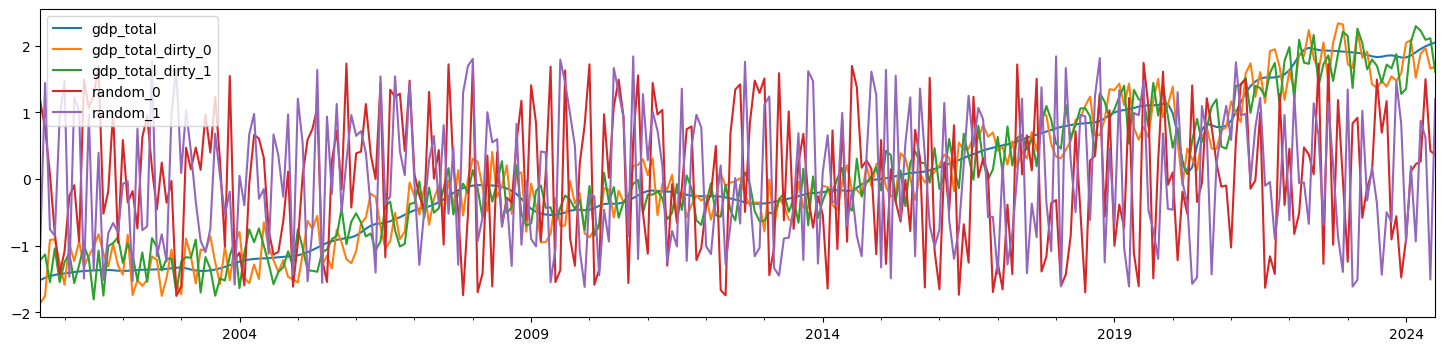

In [7706]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [7707]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [7708]:
def seasonality_test(data):
    kw_test1 = data.loc[start_date_analysis:save_some_data_for_predictions,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [7709]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)

In [7710]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [7711]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
# Causing loss of data!!!
#scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    print(i)
    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

MaandmutatieCPI_3
United States_unemply_F
United States_unemply_M
random_0
random_1


[ 4 13 15 17 20 23 27 29 31 33 34]
['Bankruptcies', 'CPI_1', 'ProducerConfidence_1', 'Crude oil, Brent', 'Natural gas index', 'M3_1', 'BCICP_NLD_CLI', 'Netherlands_unemply_F', 'United States_unemply_F', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


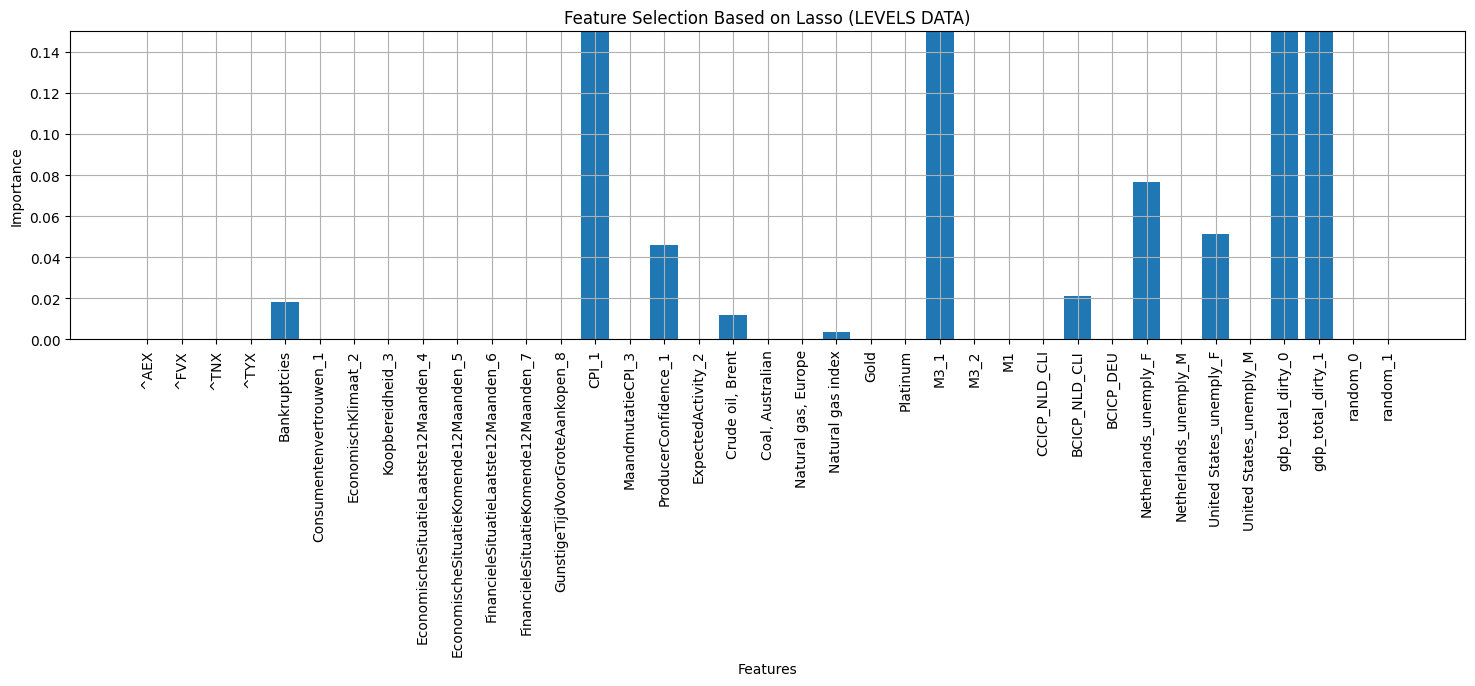

(288, 38)


In [7712]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  3  4  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25 27 28 30 31 33
 34]
['^AEX', '^TYX', 'Bankruptcies', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'MaandmutatieCPI_3', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, Brent', 'Coal, Australian', 'Natural gas, Europe', 'Natural gas index', 'Gold', 'Platinum', 'M1', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_M', 'United States_unemply_F', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


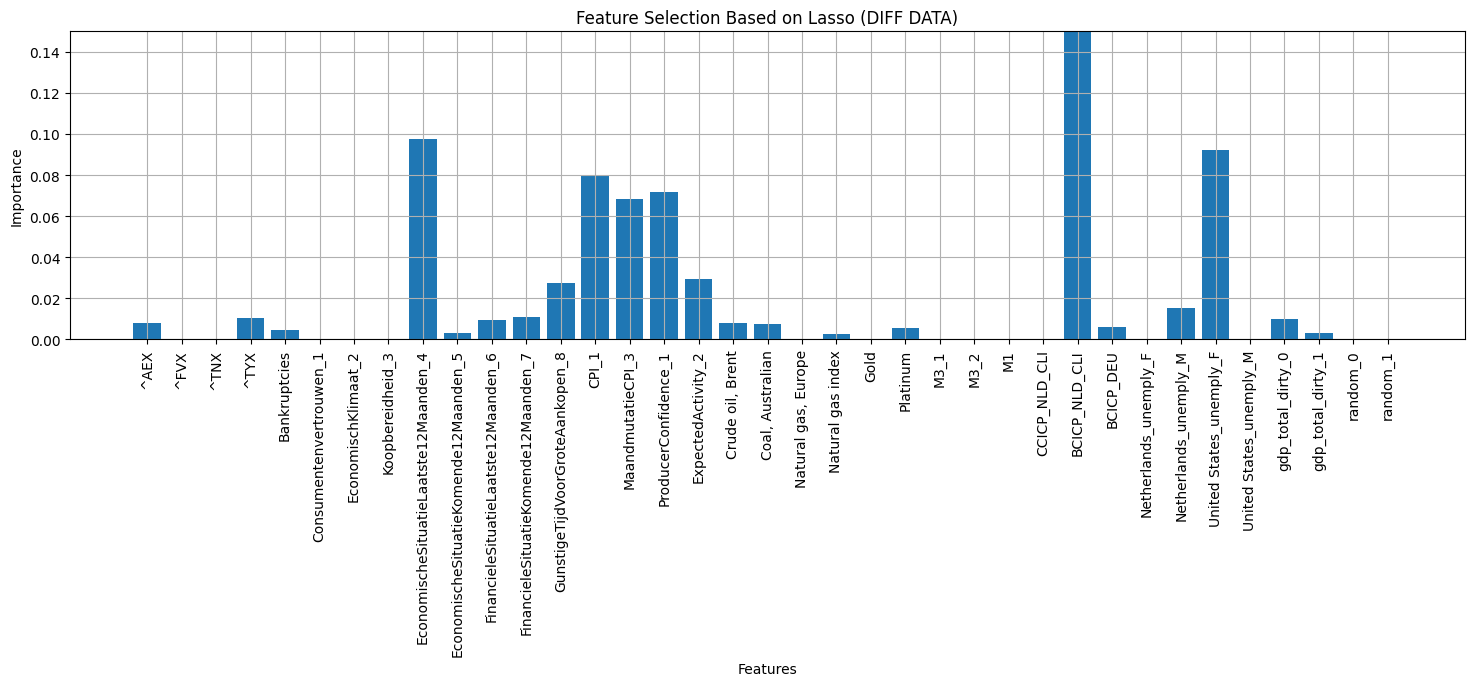

In [7713]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [7714]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])

[ 0  1  2  4  5  9 10 11 12 13 16 17 18 19 20 21 23 24 25 26 27 28 29 31
 32 33 34 35 36 37]
['gdp_total_lag_1', '^AEX_lag_1', '^FVX_lag_1', '^TYX_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'Natural gas, Europe_lag_1', 'Natural gas index_lag_1', 'Platinum_lag_1', 'M3_1_lag_1', 'M3_2_lag_1', 'M1_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


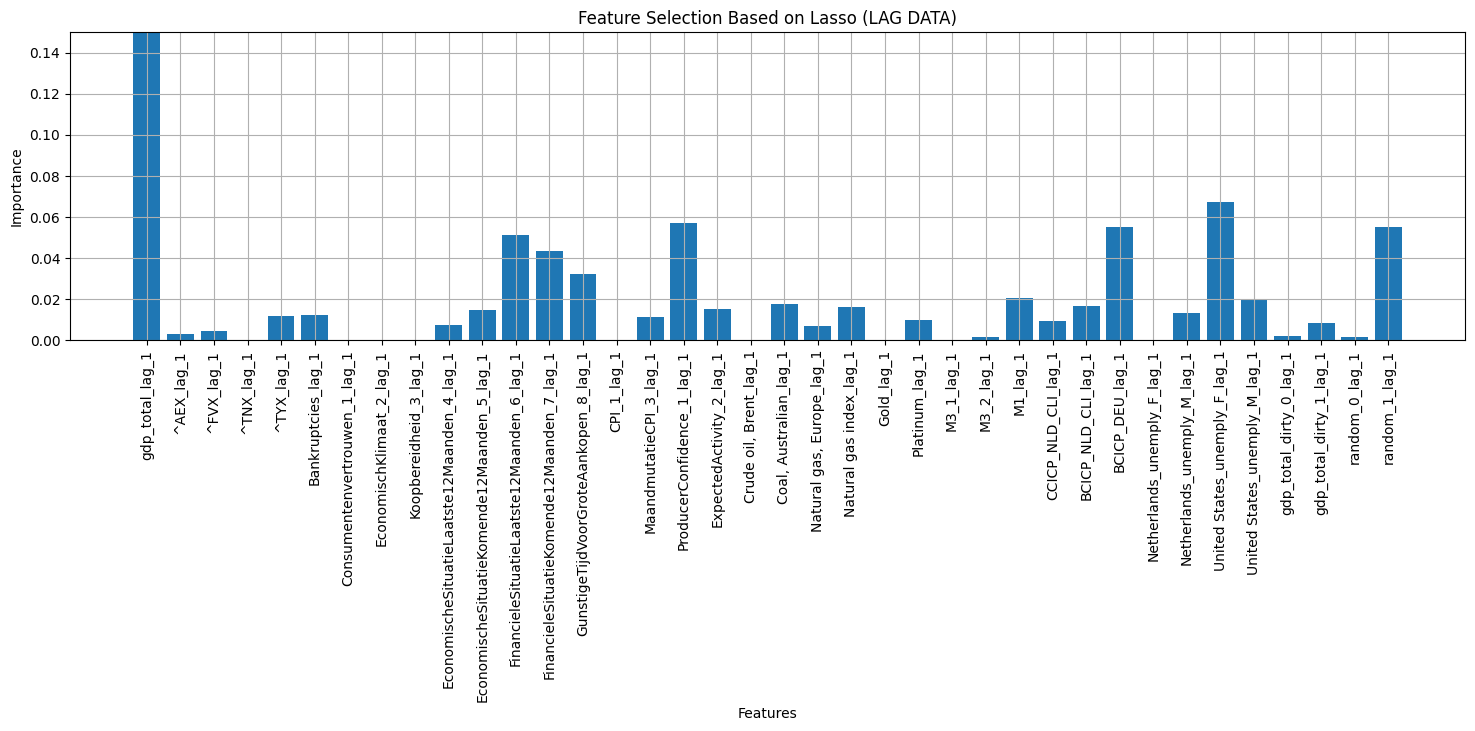

In [7715]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  4  5  9 10 11 12 13 16 17 18 19 26 28 29 31 32 35 37]
['gdp_total_lag_1', '^TYX_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'M1_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_1_lag_1', 'random_1_lag_1']


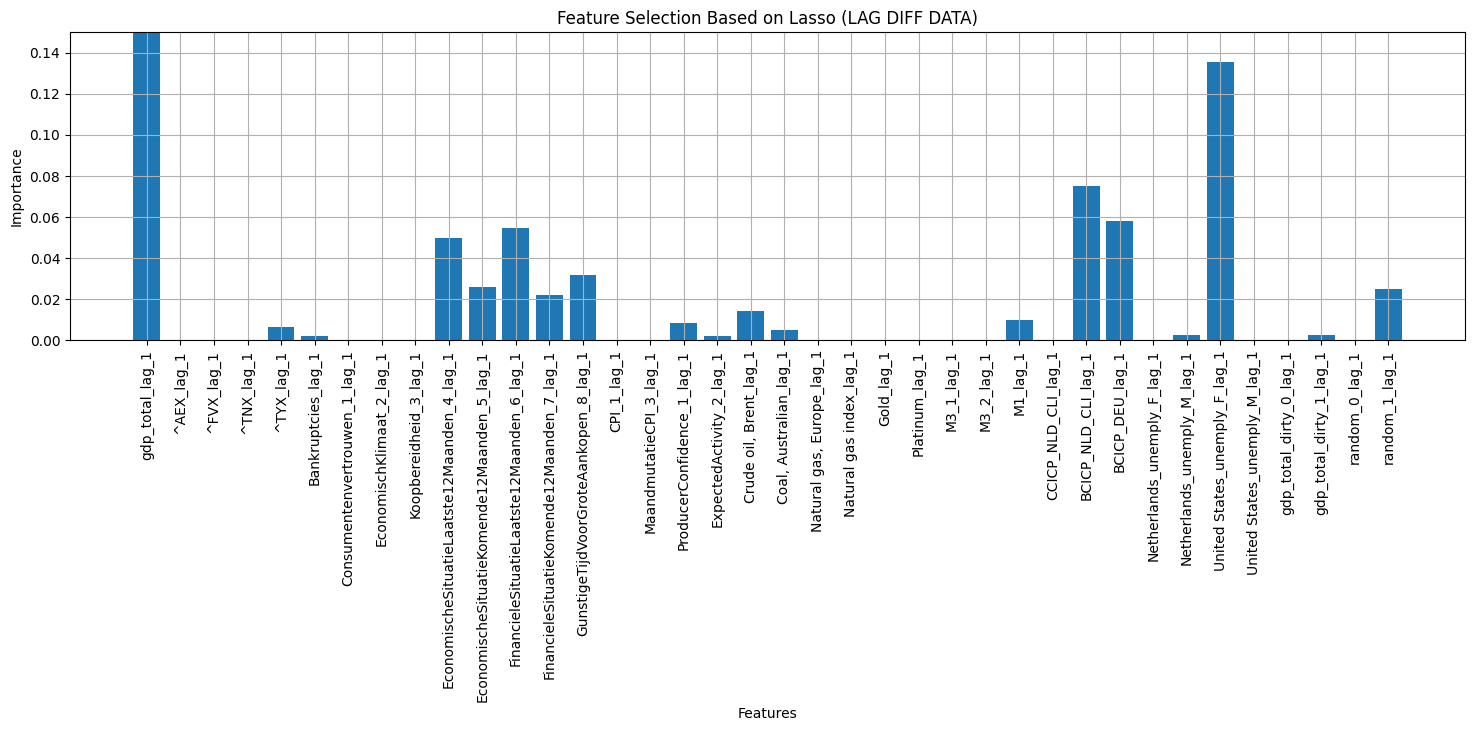

In [7716]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [7717]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(38, 3)


### If not stationary, difference, then test for stationarity again

In [7718]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]


In [7649]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
^FVX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TNX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TYX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
EconomischeSituatieLaatste12Maanden_4,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality


<Axes: >

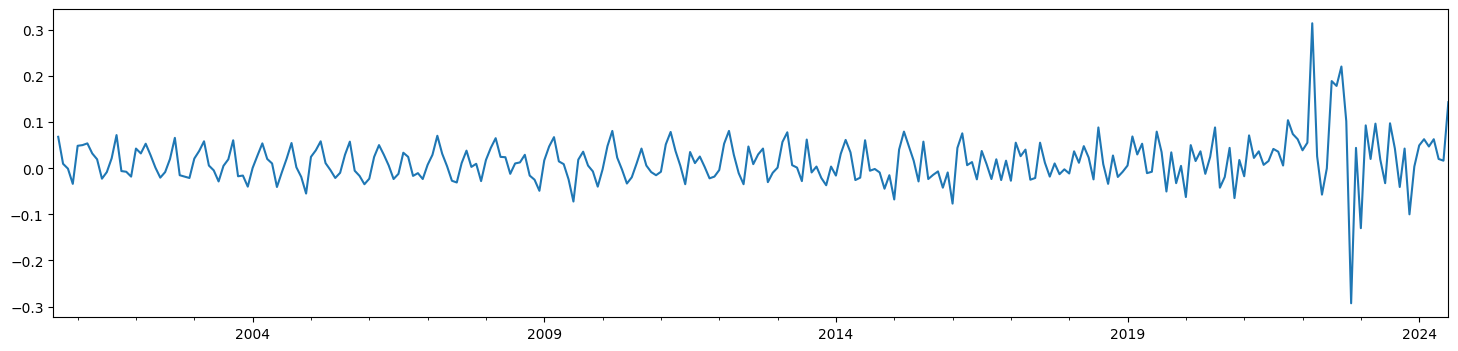

In [7650]:
scaled_features_df_diff['CPI_1'].plot()

[ 0  2  8 10 11 12 15 16 17 26 28 30 33 34 35]
['^AEX', '^TNX', 'EconomischeSituatieLaatste12Maanden_4', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, Brent', 'CCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0']


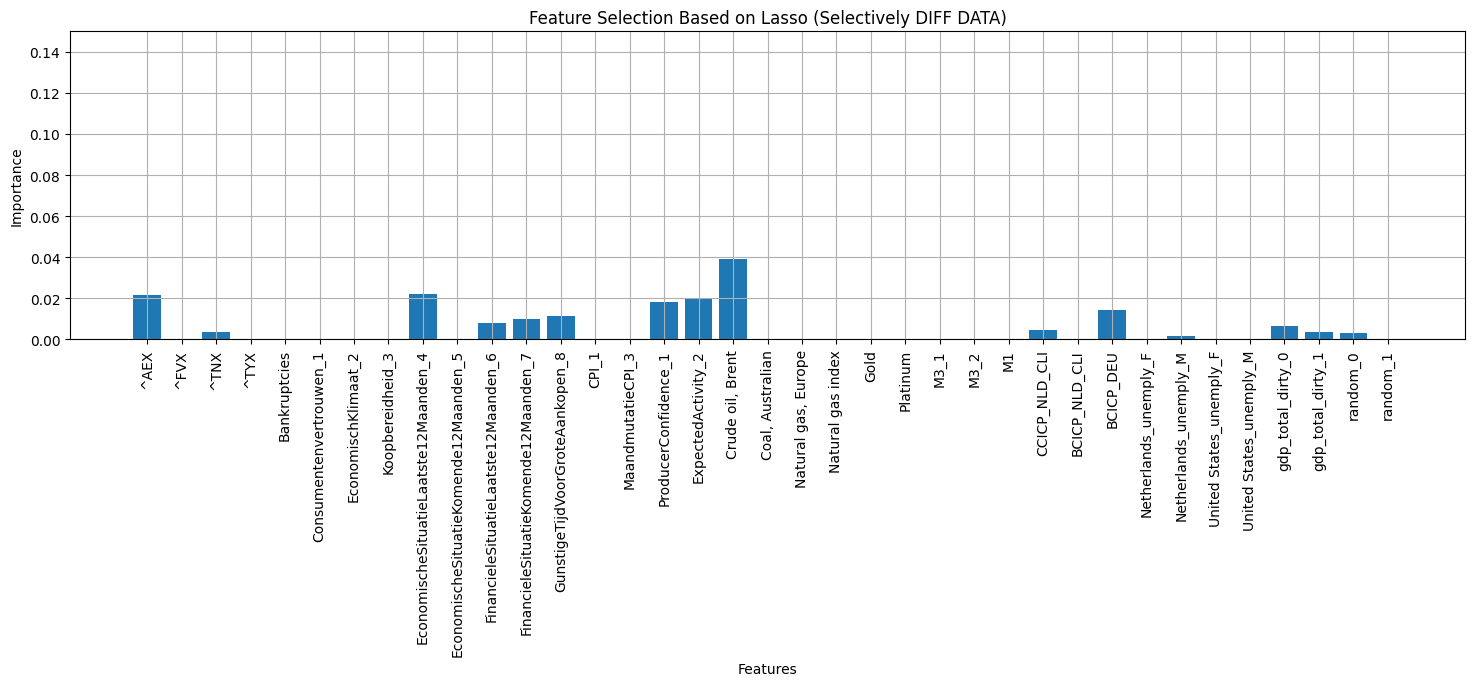

['^AEX',
 '^TNX',
 'EconomischeSituatieLaatste12Maanden_4',
 'FinancieleSituatieLaatste12Maanden_6',
 'FinancieleSituatieKomende12Maanden_7',
 'GunstigeTijdVoorGroteAankopen_8',
 'ProducerConfidence_1',
 'ExpectedActivity_2',
 'Crude oil, Brent',
 'CCICP_NLD_CLI',
 'BCICP_DEU',
 'Netherlands_unemply_M',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0']

In [7651]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

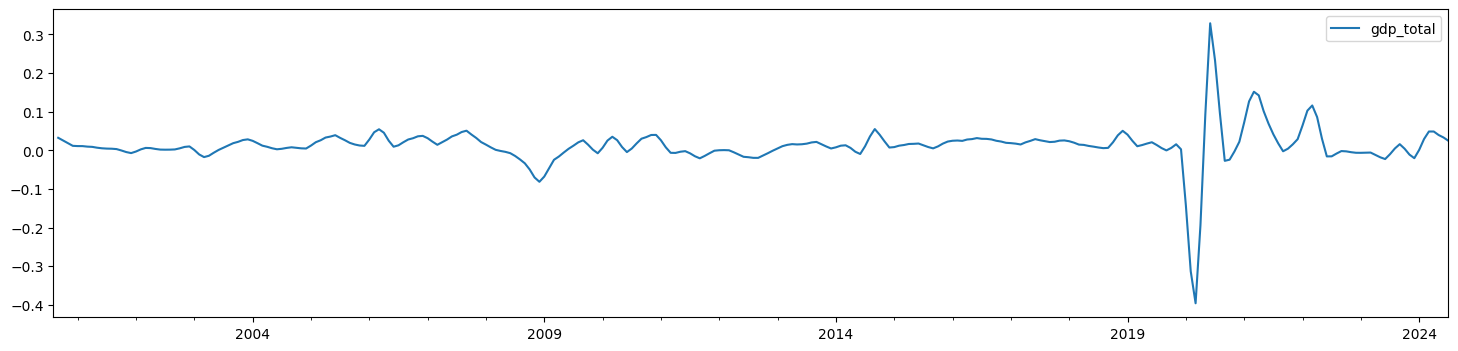

In [7652]:
scaled_features_df_diff[['gdp_total']].plot()

In [7653]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(288, 76)


In [7654]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,^AEX_lag_1,^FVX_lag_1,^TNX_lag_1,^TYX_lag_1,Bankruptcies_lag_1,Consumentenvertrouwen_1_lag_1,EconomischKlimaat_2_lag_1,Koopbereidheid_3_lag_1,...,BCICP_NLD_CLI_lag_1,BCICP_DEU_lag_1,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,0.032321,NaN,NaN,NaN,NaN,NaN,NaN,1.957691,NaN,2.550094,...,1.088987,0.383631,NaN,-1.744783,NaN,NaN,NaN,NaN,-0.857814,0.732597
2000-10-01,0.025322,0.032321,-0.075395,-0.098110,-0.026272,0.096811,-0.390466,1.909866,-0.086578,2.550094,...,1.059100,0.389560,0.187307,-1.680746,0.060627,0.060883,-0.659921,-0.238257,-0.811877,0.687921
2000-11-01,0.018557,0.025322,-0.102816,-0.105940,-0.043095,-0.016138,0.342654,2.005517,0.057719,2.618260,...,1.055790,0.385305,0.000000,-1.680746,0.060627,0.060883,0.922913,-0.272372,-0.765940,0.643244
2000-12-01,0.011511,0.018557,0.088819,-0.057178,-0.026537,-0.029532,0.219139,1.909866,-0.086578,2.550094,...,0.993095,0.341854,-0.124871,-1.680746,0.060627,0.060883,-0.555439,0.474310,-0.720003,0.598567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.048623,0.029118,0.363174,0.150917,0.127527,0.107784,-0.494059,-0.816189,-0.057719,-0.653737,...,-0.356403,-1.092977,0.000000,-0.784230,-0.035528,0.010927,0.194840,-0.032639,0.433987,0.222809
2024-04-01,0.048605,0.048623,0.126293,0.007054,-0.002924,-0.016620,-0.019922,-0.577061,0.173156,-0.449237,...,-0.302859,-1.115762,-0.124871,-0.912303,0.006849,0.014156,0.103415,0.320379,0.417377,0.251667
2024-05-01,0.039556,0.048605,0.090293,0.256484,0.268251,0.262630,0.326716,-0.529236,0.028859,-0.381070,...,-0.208817,-1.138346,-0.062436,-0.976340,0.006849,0.014156,0.151655,0.317346,0.400768,0.280524
2024-06-01,0.033191,0.039556,0.190779,-0.041911,-0.045787,-0.034391,-0.334685,-0.577061,-0.115437,-0.312904,...,-0.123439,-1.141122,-0.062436,-0.976340,0.006849,0.014156,-0.151644,0.181909,0.384158,0.309381


In [7655]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(288, 35)


[ 0  9 11 13 16 17 18 21 27 29 31]
['gdp_total_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Natural gas index_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1']


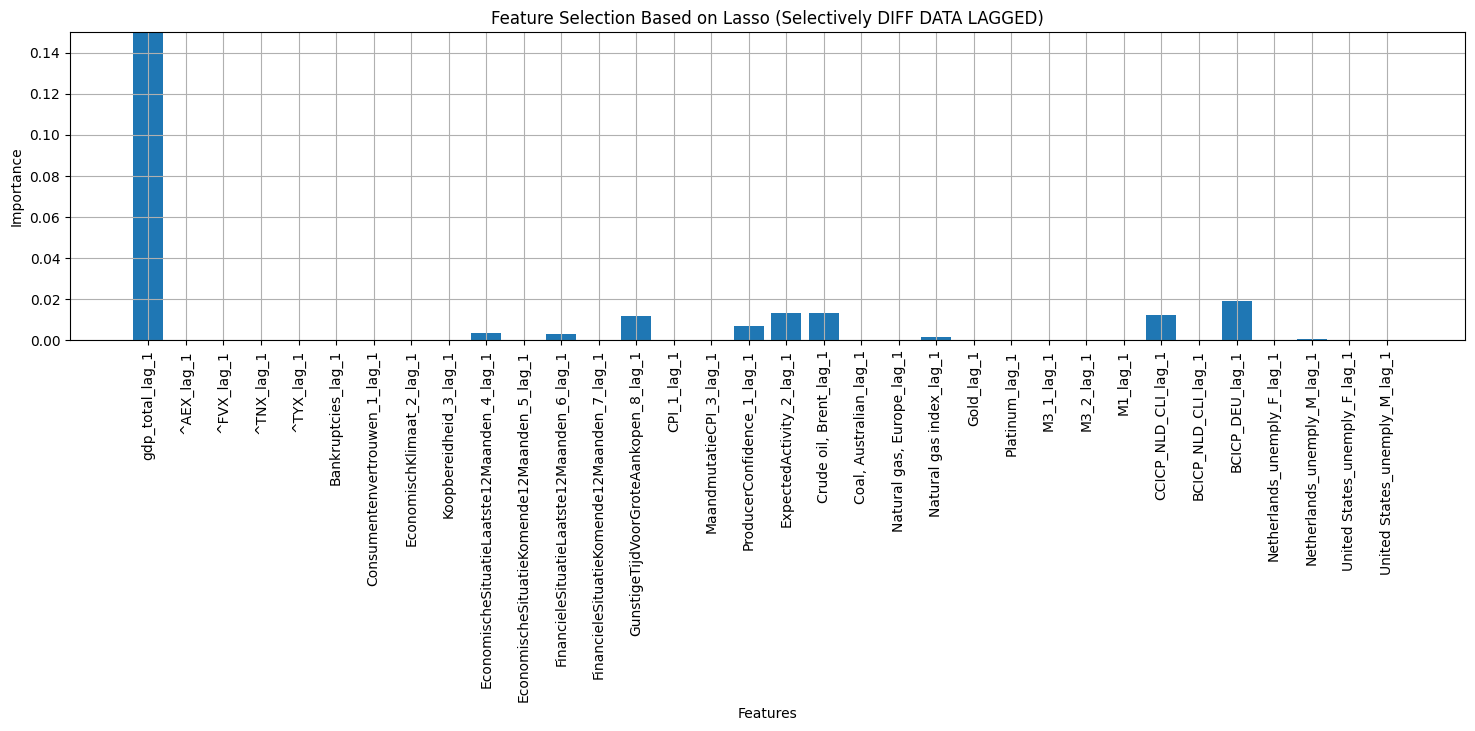

In [7656]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [7657]:
chooseThese = ['gdp_total'] + lasout
#chooseThese.remove('United States_unemply_F_lag_1')
print(chooseThese)

['gdp_total', 'gdp_total_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Natural gas index_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1']


In [7658]:
scaled_features_df_diff_lag.shape
scaled_features_df_diff_lag['gdp_total'].shape


(288,)

In [7659]:
chooseThese

['gdp_total',
 'gdp_total_lag_1',
 'EconomischeSituatieLaatste12Maanden_4_lag_1',
 'FinancieleSituatieLaatste12Maanden_6_lag_1',
 'GunstigeTijdVoorGroteAankopen_8_lag_1',
 'ProducerConfidence_1_lag_1',
 'ExpectedActivity_2_lag_1',
 'Crude oil, Brent_lag_1',
 'Natural gas index_lag_1',
 'CCICP_NLD_CLI_lag_1',
 'BCICP_DEU_lag_1',
 'Netherlands_unemply_M_lag_1']

In [7660]:
start_date_analysis

'2000-08-01'

In [7661]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2018-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())

scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     122.8
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           4.14e-82
Time:                        12:59:59   Log-Likelihood:                 741.30
No. Observations:                 210   AIC:                            -1459.
Df Residuals:                     198   BIC:                            -1418.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

,gdp_total,^AEX,^FVX,^TNX,^TYX,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,EconomischeSituatieLaatste12Maanden_4,...,BCICP_NLD_CLI_lag_1,BCICP_DEU_lag_1,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,1.957691,NaN,2.550094,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,0.032321,-0.075395,-0.098110,-0.026272,0.096811,-0.390466,1.909866,-0.086578,2.550094,-0.069314,...,1.088987,0.383631,NaN,-1.744783,NaN,NaN,NaN,NaN,-0.857814,0.732597
2000-10-01,0.025322,-0.102816,-0.105940,-0.043095,-0.016138,0.342654,2.005517,0.057719,2.618260,0.023105,...,1.059100,0.389560,0.187307,-1.680746,0.060627,0.060883,-0.659921,-0.238257,-0.811877,0.687921
2000-11-01,0.018557,0.088819,-0.057178,-0.026537,-0.029532,0.219139,1.909866,-0.086578,2.550094,-0.069314,...,1.055790,0.385305,0.000000,-1.680746,0.060627,0.060883,0.922913,-0.272372,-0.765940,0.643244
2000-12-01,0.011511,-0.187003,-0.382374,-0.384957,-0.250820,-0.537887,1.957691,0.000000,2.686427,0.000000,...,0.993095,0.341854,-0.124871,-1.680746,0.060627,0.060883,-0.555439,0.474310,-0.720003,0.598567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.048623,0.126293,0.007054,-0.002924,-0.016620,-0.019922,-0.577061,0.173156,-0.449237,0.323465,...,-0.356403,-1.092977,0.000000,-0.784230,-0.035528,0.010927,0.194840,-0.032639,0.433987,0.222809
2024-04-01,0.048605,0.090293,0.256484,0.268251,0.262630,0.326716,-0.529236,0.028859,-0.381070,0.046209,...,-0.302859,-1.115762,-0.124871,-0.912303,0.006849,0.014156,0.103415,0.320379,0.417377,0.251667
2024-05-01,0.039556,0.190779,-0.041911,-0.045787,-0.034391,-0.334685,-0.577061,-0.115437,-0.312904,-0.069314,...,-0.208817,-1.138346,-0.062436,-0.976340,0.006849,0.014156,0.151655,0.317346,0.400768,0.280524
2024-06-01,0.033191,0.106196,-0.130363,-0.143663,-0.153932,0.135468,-0.624887,0.000000,-0.449237,-0.069314,...,-0.123439,-1.141122,-0.062436,-0.976340,0.006849,0.014156,-0.151644,0.181909,0.384158,0.309381


<Axes: >

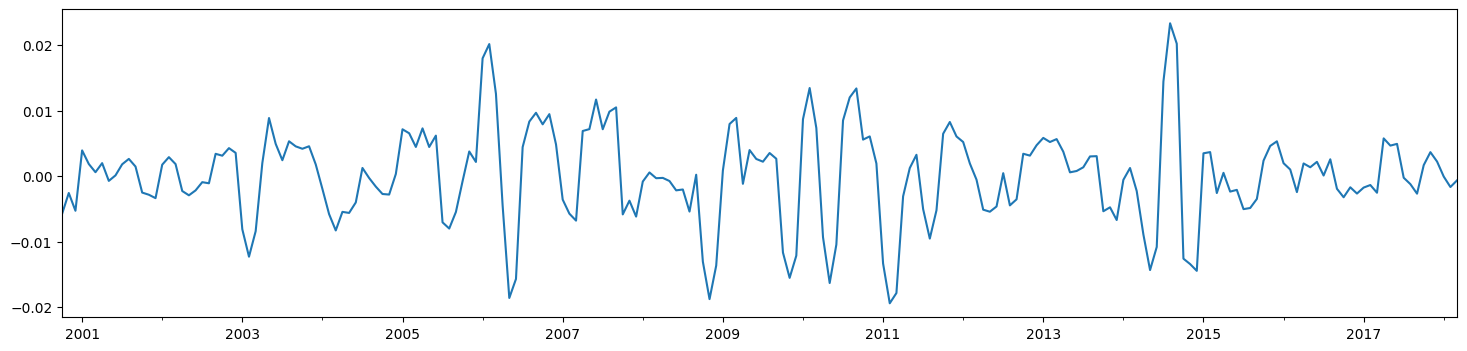

In [7662]:
results.resid.plot()

<Axes: >

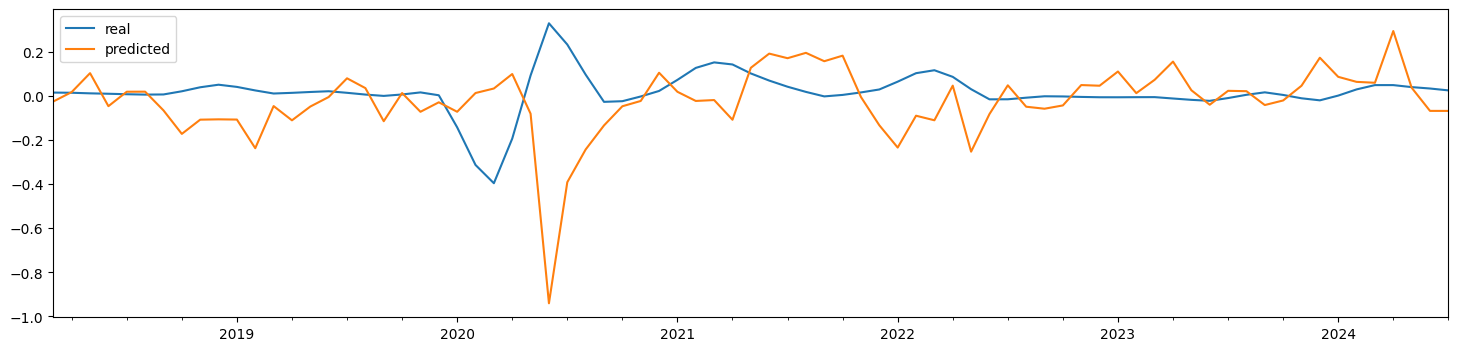

In [7663]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Heteroskedasticity (Breusch-Pagan)


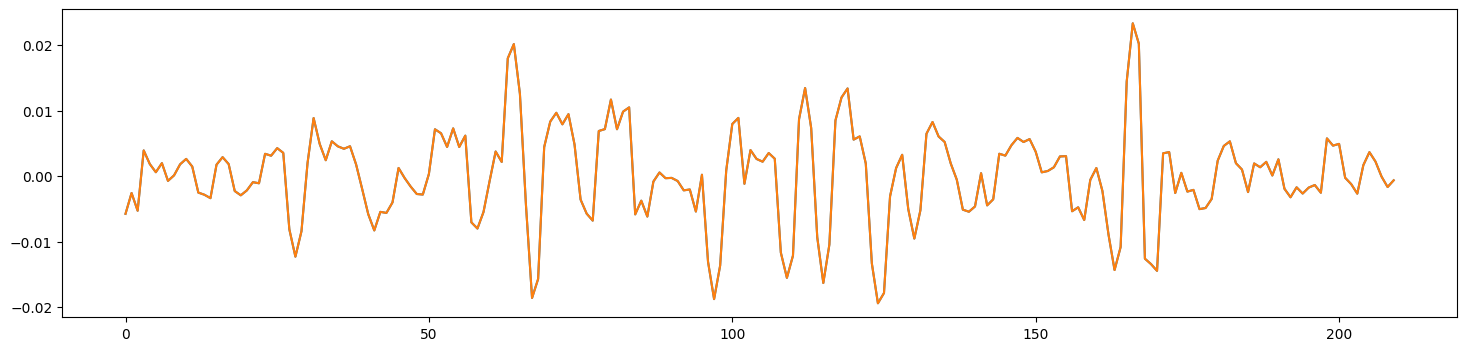

In [7664]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [7665]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [7666]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.8166635081949285
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


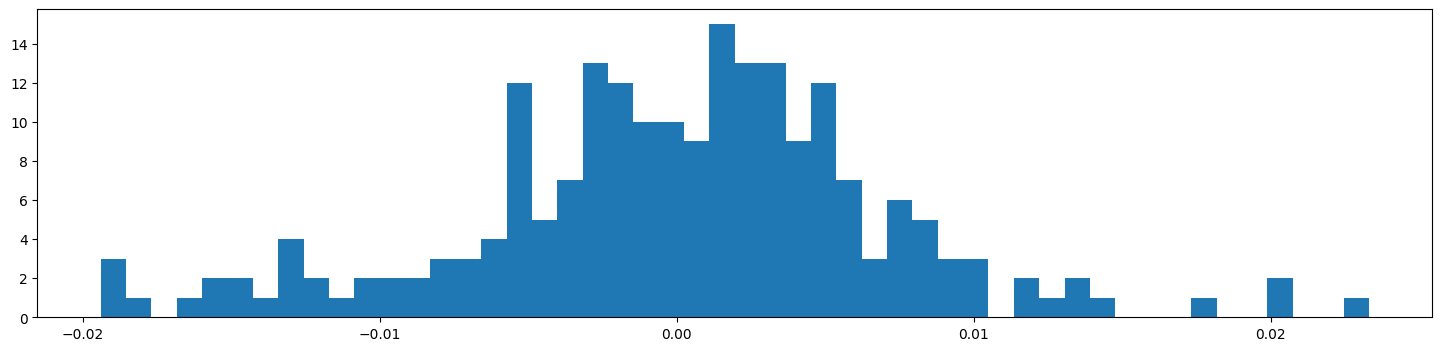

In [7667]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [7668]:
GDP_TRANSFORMATIONS.tail(25)

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2022-07-01,235555.000000,1.934895,-0.015667
2022-08-01,235386.092912,1.926440,-0.008455
2022-09-01,235345.770002,1.924422,-0.002018
2022-10-01,235290.000000,1.921630,-0.002792
2022-11-01,235191.035253,1.916676,-0.004954
2022-12-01,235062.049601,1.910219,-0.006457
2023-01-01,234931.000000,1.903659,-0.006560
2023-02-01,234808.972706,1.897551,-0.006108
2023-03-01,234691.322163,1.891662,-0.005889
2023-04-01,234449.000000,1.879532,-0.012130


In [7669]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2000-08-01,166653.477407,-1.514151,NaN
2000-09-01,167299.152264,-1.481830,0.032321
2000-10-01,167805.000000,-1.456508,0.025322
2000-11-01,168175.711673,-1.437951,0.018557
2000-12-01,168405.657073,-1.426441,0.011511
...,...,...,...
2024-03-01,234863.025267,1.900257,0.048623
2024-04-01,235834.000000,1.948861,0.048605
2024-05-01,236624.203208,1.988417,0.039556
2024-06-01,237287.255097,2.021608,0.033191


In [7670]:

def test_reverse_transform(start_date_analysis):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = y_true
    date_start_difference = pd.to_datetime(start_date_analysis) + relativedelta(months=1)

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    print(test1)

test_reverse_transform(start_date_analysis)




[167299.15226442 167805.         168175.71167258 168405.65707324
 168623.         168838.7908214  169028.27361134 169205.
 169338.52610036 169441.69370363 169529.         169610.22853512
 169672.31356948 169662.         169569.66290756 169424.29932432
 169360.         169407.24914254 169529.85214747 169643.
 169712.3619279  169748.20703879 169779.         169812.12276888
 169855.82851219 169957.         170130.91041046 170330.69222412
 170347.         170132.41455196 169780.16065737 169495.
 169368.12817219 169385.78375589 169520.         169774.69183474
 170142.50150936 170579.         171109.05783254 171674.66445726
 172164.         172531.68165651 172771.02805786 172951.
 173056.12508483 173107.89348256 173185.         173307.27315504
 173462.59090575 173591.         173691.92686268 173783.52215767
 174026.         174444.53352293 174963.52951701 175622.
 176331.91165506 177112.6273914  177755.         178273.9143448
 178656.67690891 178957.         179204.05162183 179434.09787347
 

In [7671]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2000-08-01,166653.477407,-1.514151,NaN
2000-09-01,167299.152264,-1.481830,0.032321
2000-10-01,167805.000000,-1.456508,0.025322
2000-11-01,168175.711673,-1.437951,0.018557
2000-12-01,168405.657073,-1.426441,0.011511
...,...,...,...
2024-03-01,234863.025267,1.900257,0.048623
2024-04-01,235834.000000,1.948861,0.048605
2024-05-01,236624.203208,1.988417,0.039556
2024-06-01,237287.255097,2.021608,0.033191


In [7672]:
df_pred

,real,predicted
2018-03-01,0.014708,-0.025633
2018-04-01,0.013919,0.017099
2018-05-01,0.011278,0.102821
2018-06-01,0.009421,-0.046873
2018-07-01,0.007233,0.018588
...,...,...
2024-03-01,0.048623,0.059225
2024-04-01,0.048605,0.293755
2024-05-01,0.039556,0.036900
2024-06-01,0.033191,-0.068268


In [7673]:
GDP_TRANSFORMATIONS.loc['2018-03-01':,:].head(25)

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2018-03-01,212768.947893,0.794280,0.014708
2018-04-01,213047.000000,0.808198,0.013919
2018-05-01,213272.305166,0.819477,0.011278
2018-06-01,213460.507638,0.828898,0.009421
2018-07-01,213605.000000,0.836131,0.007233
2018-08-01,213715.642730,0.841669,0.005539
2018-09-01,213839.937958,0.847891,0.006222
2018-10-01,214252.000000,0.868518,0.020627
2018-11-01,215026.429552,0.907284,0.038766
2018-12-01,216033.401665,0.957691,0.050407


In [7674]:
df_pred

,real,predicted
2018-03-01,0.014708,-0.025633
2018-04-01,0.013919,0.017099
2018-05-01,0.011278,0.102821
2018-06-01,0.009421,-0.046873
2018-07-01,0.007233,0.018588
...,...,...
2024-03-01,0.048623,0.059225
2024-04-01,0.048605,0.293755
2024-05-01,0.039556,0.036900
2024-06-01,0.033191,-0.068268


In [7675]:
GDP_TRANSFORMATIONS.head()

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2000-08-01,166653.477407,-1.514151,NaN
2000-09-01,167299.152264,-1.481830,0.032321
2000-10-01,167805.000000,-1.456508,0.025322
2000-11-01,168175.711673,-1.437951,0.018557
2000-12-01,168405.657073,-1.426441,0.011511


In [7676]:
ynewpred

2018-03-01   -0.025633
2018-04-01    0.017099
2018-05-01    0.102821
2018-06-01   -0.046873
2018-07-01    0.018588
                ...   
2024-03-01    0.059225
2024-04-01    0.293755
2024-05-01    0.036900
2024-06-01   -0.068268
2024-07-01   -0.068388
Length: 77, dtype: float64

In [7677]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2000-08-01,166653.477407,-1.514151,NaN
2000-09-01,167299.152264,-1.481830,0.032321
2000-10-01,167805.000000,-1.456508,0.025322
2000-11-01,168175.711673,-1.437951,0.018557
2000-12-01,168405.657073,-1.426441,0.011511
...,...,...,...
2024-03-01,234863.025267,1.900257,0.048623
2024-04-01,235834.000000,1.948861,0.048605
2024-05-01,236624.203208,1.988417,0.039556
2024-06-01,237287.255097,2.021608,0.033191


In [7678]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
2000-08-01,166653.477407,-1.514151,NaN
2000-09-01,167299.152264,-1.481830,0.032321
2000-10-01,167805.000000,-1.456508,0.025322
2000-11-01,168175.711673,-1.437951,0.018557
2000-12-01,168405.657073,-1.426441,0.011511
...,...,...,...
2024-03-01,234863.025267,1.900257,0.048623
2024-04-01,235834.000000,1.948861,0.048605
2024-05-01,236624.203208,1.988417,0.039556
2024-06-01,237287.255097,2.021608,0.033191


In [7679]:
date_start_difference = pd.to_datetime(start_date_analysis) + relativedelta(months=1)

In [7683]:
reformData

np.float64(-1.4818299500875494)

In [7682]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

reformData = GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']

GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations
2000-08-01,166653.477407,-1.514151,NaN,NaN
2000-09-01,167299.152264,-1.481830,0.032321,0.032321
2000-10-01,167805.000000,-1.456508,0.025322,0.025322
2000-11-01,168175.711673,-1.437951,0.018557,0.018557
2000-12-01,168405.657073,-1.426441,0.011511,0.011511
...,...,...,...,...
2024-03-01,234863.025267,1.900257,0.048623,0.059225
2024-04-01,235834.000000,1.948861,0.048605,0.293755
2024-05-01,236624.203208,1.988417,0.039556,0.036900
2024-06-01,237287.255097,2.021608,0.033191,-0.068268


In [7685]:
GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:]

array([ 3.23209472e-02,  2.53215341e-02,  1.85569443e-02,  1.15105197e-02,
        1.08796698e-02,  1.08019751e-02,  9.48505765e-03,  8.84650255e-03,
        6.68399890e-03,  5.16432476e-03,  4.37034548e-03,  4.06610721e-03,
        3.10782911e-03, -5.16272750e-04, -4.62217516e-03, -7.27655513e-03,
       -3.21867119e-03,  2.36517966e-03,  6.13721473e-03,  5.66391230e-03,
        3.47209308e-03,  1.79432097e-03,  1.54142238e-03,  1.65804700e-03,
        2.18780553e-03,  5.06440397e-03,  8.70554138e-03,  1.00006023e-02,
        8.16328461e-04, -1.07416370e-02, -1.76329919e-02, -1.42744641e-02,
       -6.35090185e-03,  8.83796514e-04,  6.71854585e-03,  1.27492673e-02,
        1.84116772e-02,  2.18500759e-02,  2.65334340e-02,  2.83129219e-02,
        2.44949730e-02,  1.84052689e-02,  1.19811114e-02,  9.00896723e-03,
        5.26231163e-03,  2.59140282e-03,  3.85976881e-03,  6.12070323e-03,
        7.77483707e-03,  6.42785375e-03,  5.05215862e-03,  4.58504254e-03,
        1.21378639e-02,  

In [7687]:
diff_inv_Transformation(GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:], reformData)

array([-1.48182995e+00, -1.44950900e+00, -1.42418747e+00, -1.40563052e+00,
       -1.39412000e+00, -1.38324033e+00, -1.37243836e+00, -1.36295330e+00,
       -1.35410680e+00, -1.34742280e+00, -1.34225848e+00, -1.33788813e+00,
       -1.33382202e+00, -1.33071419e+00, -1.33123047e+00, -1.33585264e+00,
       -1.34312920e+00, -1.34634787e+00, -1.34398269e+00, -1.33784547e+00,
       -1.33218156e+00, -1.32870947e+00, -1.32691515e+00, -1.32537373e+00,
       -1.32371568e+00, -1.32152787e+00, -1.31646347e+00, -1.30775793e+00,
       -1.29775733e+00, -1.29694100e+00, -1.30768263e+00, -1.32531563e+00,
       -1.33959009e+00, -1.34594099e+00, -1.34505719e+00, -1.33833865e+00,
       -1.32558938e+00, -1.30717770e+00, -1.28532763e+00, -1.25879419e+00,
       -1.23048127e+00, -1.20598630e+00, -1.18758103e+00, -1.17559992e+00,
       -1.16659095e+00, -1.16132864e+00, -1.15873724e+00, -1.15487747e+00,
       -1.14875677e+00, -1.14098193e+00, -1.13455407e+00, -1.12950192e+00,
       -1.12491687e+00, -

In [7689]:
std_inv_Transformation(GDP_TRANSFORMATIONS['gdp_total_scaled'].values)

array([151334.91833677, 152149.51490146, 152787.70271854, 153255.40012321,
       153545.5039291 , 153819.70819697, 154091.95429707, 154331.00964827,
       154553.97126353, 154722.43051424, 154852.58886604, 154962.73626965,
       155065.21584575, 155143.54359097, 155130.53178143, 155014.03742291,
       154830.64376245, 154749.52242387, 154809.13290547, 154963.81135627,
       155106.56099403, 155194.06941651, 155239.29233926, 155278.14136697,
       155319.92972754, 155375.06978443, 155502.70979627, 155722.11871601,
       155974.16752553, 155994.74174808, 155724.0163716 , 155279.60567598,
       154919.84117642, 154759.77709162, 154782.05173601, 154951.38168615,
       155272.70609784, 155736.74228272, 156287.4376784 , 156956.16944742,
       157669.75029748, 158287.1059954 , 158750.98067002, 159052.94497007,
       159280.00124176, 159412.62919221, 159477.9412583 , 159575.22041285,
       159729.48271831, 159925.43475943, 160087.4382909 , 160214.76967868,
       160330.32817041, 1

In [ ]:

std_inv_Transformation(diff_inv_Transformation(GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:], reformData))

predictions


array([152149.51490146, 152964.11146615, 153602.29928323, 154069.9966879 ,
       154360.10049379, 154634.30476166, 154906.55086176, 155145.60621296,
       155368.56782822, 155537.02707893, 155667.18543073, 155777.33283435,
       155879.81241044, 155958.14015566, 155945.12834612, 155828.6339876 ,
       155645.24032714, 155564.11898856, 155623.72947016, 155778.40792096,
       155921.15755872, 156008.6659812 , 156053.88890395, 156092.73793166,
       156134.52629223, 156189.66634912, 156317.30636096, 156536.7152807 ,
       156788.76409022, 156809.33831277, 156538.61293629, 156094.20224067,
       155734.43774111, 155574.37365631, 155596.6483007 , 155765.97825084,
       156087.30266253, 156551.33884741, 157102.03424309, 157770.76601212,
       158484.34686217, 159101.70256009, 159565.57723471, 159867.54153476,
       160094.59780645, 160227.2257569 , 160292.53782299, 160389.81697755,
       160544.079283  , 160740.03132412, 160902.03485559, 161029.36624337,
       161144.9247351 , 1

In [ ]:

b = df_pred['predicted'].values
nans = GDP_TRANSFORMATIONS.shape[0] - len(b)
GDP_TRANSFORMATIONS['predictions_scaled_diff'] = np.repeat(np.nan, nans).tolist() + b.tolist()
GDP_TRANSFORMATIONS.to_csv("tmp_GDP_TRANSFORMS.csv")

In [ ]:
date_start_test_difference = pd.to_datetime(test_start_date) + relativedelta(months=1)
date_start_test_difference

In [ ]:
GDP_TRANSFORMATIONS.loc[date_start_test_difference, 'gdp_total_scaled']

In [ ]:
GDP_TRANSFORMATIONS.loc[test_start_date:, 'xx'] = std_inv_Transformation(diff_inv_Transformation(GDP_TRANSFORMATIONS.loc[date_start_test_difference:, 'predictions_scaled_diff'].values[1:], GDP_TRANSFORMATIONS.loc[date_start_test_difference, 'gdp_total_scaled']))

In [ ]:
GDP_TRANSFORMATIONS

In [ ]:
GDP_TRANSFORMATIONS

In [ ]:
len(a)

In [ ]:
len(b)

In [ ]:
hist_pred['xx'] = std_inv_Transformation(diff_inv_Transformation(hist_pred['myPredictions'].values[1:], GDP_TRANSFORMATIONS.loc['2022-11-01', 'gdp_total_scaled']))
hist_pred['xx'].plot()

In [ ]:
GDP_TRANSFORMATIONS